### Tester CRF pour la détection des NER genes

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import sys  
sys.path.insert(0, '/home/user/PPD_project/CRF')
from CFRs_functions import *

In [3]:
import nltk
import csv
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, pos_tag, pos_tag_sents
import nltk.tag
from sklearn.model_selection import learning_curve
from itertools import chain
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
import pycrfsuite
import io
from collections import Counter

In [4]:
import sklearn_crfsuite
import eli5
import scipy.stats

from sklearn.model_selection import train_test_split
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn_crfsuite.metrics import sequence_accuracy_score,flat_accuracy_score, flat_recall_score,flat_precision_score

Using TensorFlow backend.


In [5]:
# Pos_tag_corpus : fonction pour ajouter les POS au corpus

In [6]:
corpus_training_with_pos = Pos_tag_corpus("JNLPBA _Corpus/train.tsv")
corpus_testing_with_pos = Pos_tag_corpus("JNLPBA _Corpus/test.tsv")
corpus_devel_with_pos = Pos_tag_corpus("JNLPBA _Corpus/devel.tsv")

In [7]:
# Distrubition des tag 

In [8]:
tag_distribution = corpus_training_with_pos.groupby("tag").size().reset_index(name='counts')
print(tag_distribution)

            tag  counts
0         B-DNA    6659
1         B-RNA     731
2   B-cell_line    2912
3   B-cell_type    4611
4     B-protein   11791
5         E-DNA    6660
6         E-RNA     731
7   E-cell_line    2912
8   E-cell_type    4612
9     E-protein   11791
10        I-DNA    7408
11        I-RNA     617
12  I-cell_line    3707
13  I-cell_type    3520
14    I-protein   10646
15            O  345732
16        S-DNA    1821
17        S-RNA     113
18  S-cell_line     518
19  S-cell_type    1580
20    S-protein   16012


In [9]:
## Save les données avec POS et Class
corpus_training_with_pos.to_csv('POS_JNLPBA/train_pos.tsv',sep='\t',index=False, header=False)
corpus_testing_with_pos.to_csv('POS_JNLPBA/test_pos.tsv',sep='\t',index=False, header=False)
corpus_devel_with_pos.to_csv('POS_JNLPBA/dev_pos.tsv',sep='\t',index=False, header=False)

In [10]:
corpus_training = corpus_preprocessing("POS_JNLPBA/train_pos.tsv")
corpus_testing = corpus_preprocessing("POS_JNLPBA/test_pos.tsv")
corpus_devel = corpus_preprocessing("POS_JNLPBA/dev_pos.tsv")

In [11]:
X_dev = sent2features(corpus_devel)
X_dev = [[i] for i in X_dev]
y_dev = sent2labels(corpus_devel)
y_dev = [[i] for i in y_dev]

In [12]:
## split_data_train_test : fonction pour spliter les datas 

In [13]:
X_train, y_train, X_test, y_test = split_data_train_test(corpus_training, corpus_testing)

## Train a CRF model

In [14]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
)
crf.fit(X_train, y_train);

In [15]:
import eli5
eli5.show_weights(crf, show=['targets'])

In [16]:
labels = list(crf.classes_)
labels.remove('O')
labels

['E-DNA',
 'B-protein',
 'E-protein',
 'S-protein',
 'I-protein',
 'B-cell_type',
 'I-cell_type',
 'E-cell_type',
 'B-DNA',
 'I-DNA',
 'S-cell_type',
 'S-DNA',
 'S-cell_line',
 'B-cell_line',
 'E-cell_line',
 'I-cell_line',
 'B-RNA',
 'I-RNA',
 'E-RNA',
 'S-RNA']

In [18]:
## cross validation de model 

In [17]:
pred = cross_val_predict(estimator=crf, X = X_train,y = y_train, cv=10)

In [18]:
report = flat_classification_report(y_pred=pred, y_true=y_train)
print(report)
f1 = flat_f1_score(y_train, pred, average='weighted', labels=labels)
print("F1 weighted avg: " + str(f1))

              precision    recall  f1-score   support

       B-DNA       0.68      0.55      0.61      6659
       B-RNA       0.81      0.56      0.67       731
 B-cell_line       0.68      0.50      0.58      2912
 B-cell_type       0.72      0.66      0.69      4611
   B-protein       0.71      0.66      0.68     11791
       E-DNA       0.81      0.80      0.80      6660
       E-RNA       0.84      0.83      0.84       731
 E-cell_line       0.80      0.66      0.73      2912
 E-cell_type       0.77      0.86      0.81      4612
   E-protein       0.78      0.79      0.79     11791
       I-DNA       0.68      0.50      0.58      7408
       I-RNA       0.66      0.24      0.35       617
 I-cell_line       0.70      0.53      0.60      3707
 I-cell_type       0.67      0.65      0.66      3520
   I-protein       0.69      0.58      0.63     10646
           O       0.95      0.97      0.96    345732
       S-DNA       0.63      0.37      0.47      1821
       S-RNA       0.66    

In [21]:
## On test sur les données test et dev 

In [20]:
y_pred = crf.predict(X_test)
flat_f1_score(y_test, y_pred,average='weighted', labels=labels)

0.6654102177395056

In [21]:
y_pred = crf.predict(X_dev)
flat_f1_score(y_dev, y_pred,average='weighted', labels=labels)

0.6936699302255168

In [22]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(flat_classification_report(
    y_dev, y_pred, labels=sorted_labels, digits=3
))

accuracy = flat_accuracy_score(y_dev, y_pred)
print("Accuracy: " + str(accuracy))
f1 = flat_f1_score(y_dev, y_pred, average='weighted', labels=labels)
precision = flat_precision_score(y_dev, y_pred, average='weighted', labels=labels)
print("Precision : "  + str(precision))

recall =flat_recall_score(y_dev, y_pred, average='weighted', labels=labels)
print("Recall : " + str(recall))
print("F1 weighted avg: " + str(f1))

              precision    recall  f1-score   support

       B-DNA      0.731     0.589     0.652       825
       E-DNA      0.808     0.836     0.822       825
       I-DNA      0.731     0.545     0.624       881
       S-DNA      0.611     0.388     0.474       227
       B-RNA      0.790     0.533     0.636        92
       E-RNA      0.905     0.826     0.864        92
       I-RNA      0.545     0.133     0.214        90
       S-RNA      0.667     0.400     0.500        15
 B-cell_line      0.736     0.493     0.590       339
 E-cell_line      0.863     0.652     0.743       339
 I-cell_line      0.813     0.538     0.648       429
 S-cell_line      0.792     0.311     0.447        61
 B-cell_type      0.695     0.677     0.686       400
 E-cell_type      0.738     0.873     0.800       400
 I-cell_type      0.529     0.667     0.590       216
 S-cell_type      0.882     0.714     0.789       126
   B-protein      0.720     0.639     0.677      1293
   E-protein      0.806    

## Plot learning curves for the optimised model

La performance du modèle peut être évaluée à l'aide d'une courbe d'apprentissage, en traçant la précision des prédictions sur les ensembles de données de formation et de test au fur et à mesure que des données de formation supplémentaires sont introduites dans le modèle. Comme on peut s'y attendre, la précision des données de test augmente avec le nombre d'échantillons de formation.

[learning_curve] Training set sizes: [ 29672  59344  89016 118688 148361 178033 207705 237377 267049 296722]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 18.2min finished


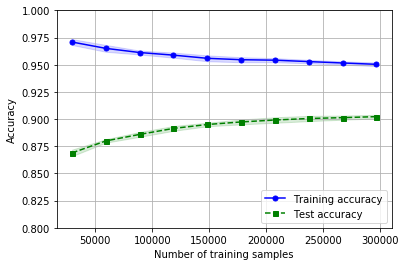

In [23]:
# Produce the necessary data for a learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=crf,
                                                        X=X_train,
                                                        y=y_train,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=3,
                                                        verbose=1,
                                                        n_jobs=-1)

# Find the means and standard deviations of the training and test datasets across the learning curve
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std)

In [24]:
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(flat_f1_score,average='weighted', labels=labels)
# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 97.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=0.1, c2=0.1,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_te...
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['E-DNA', 'B-protein', 'E-protein', 'S-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'E-cell_type', 'B-DNA

In [32]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.45404577695939724, 'c2': 0.06867228122697551}
best CV score: 0.6895521760354318
model size: 2.69M


In [33]:
crf = rs.best_estimator_
y_pred = crf.predict(X_dev)
print(flat_classification_report(
    y_dev, y_pred, labels=sorted_labels, digits=3
))

accuracy = flat_accuracy_score(y_dev, y_pred)
print("accuracy :" + str(accuracy))
precision = flat_precision_score(y_dev, y_pred, average='weighted', labels=labels)
print("Precision : "  + str(precision))
recall = flat_recall_score(y_dev, y_pred, average='weighted', labels=labels)
print("Recall : " + str(recall))
f1 = flat_f1_score(y_dev, y_pred, average='weighted', labels=labels)
print("F1 weighted avg: " + str(f1))

              precision    recall  f1-score   support

       B-DNA      0.734     0.571     0.642       825
       E-DNA      0.807     0.841     0.824       825
       I-DNA      0.717     0.544     0.618       881
       S-DNA      0.628     0.401     0.489       227
       B-RNA      0.778     0.533     0.632        92
       E-RNA      0.885     0.837     0.860        92
       I-RNA      0.769     0.222     0.345        90
       S-RNA      0.667     0.400     0.500        15
 B-cell_line      0.730     0.487     0.584       339
 E-cell_line      0.878     0.661     0.754       339
 I-cell_line      0.823     0.541     0.653       429
 S-cell_line      0.826     0.311     0.452        61
 B-cell_type      0.712     0.667     0.689       400
 E-cell_type      0.746     0.882     0.809       400
 I-cell_type      0.543     0.708     0.614       216
 S-cell_type      0.880     0.698     0.779       126
   B-protein      0.721     0.647     0.682      1293
   E-protein      0.806    

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Dark blue => 0.6653, dark red => 0.6896


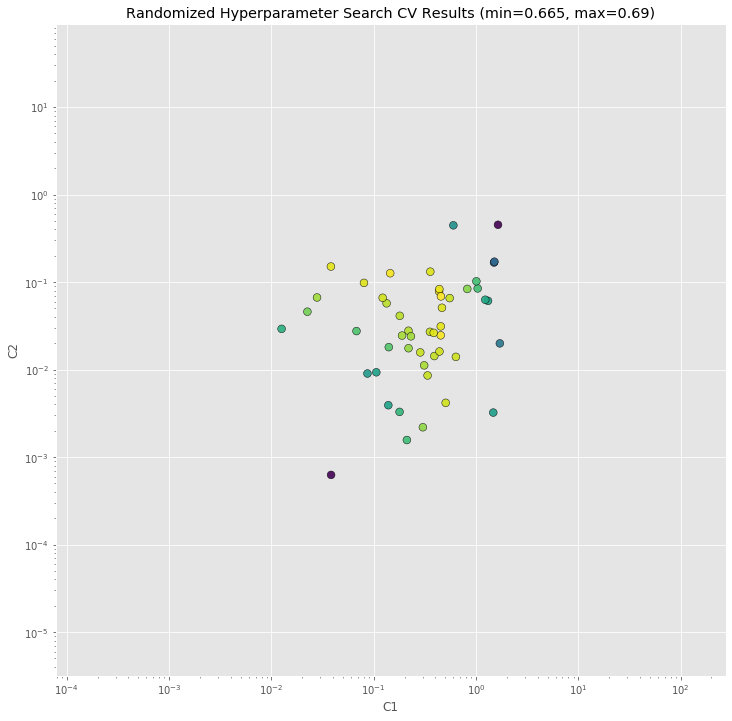

In [35]:
_x = rs.cv_results_['param_c1'].tolist()
_y = rs.cv_results_['param_c2'].tolist()
_c = rs.cv_results_['mean_test_score'].tolist()

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [36]:
crf = rs.best_estimator_
y_pred = crf.predict(X_dev)
print(flat_classification_report(
    y_dev, y_pred, labels = sorted_labels, digits = 3
))

              precision    recall  f1-score   support

       B-DNA      0.734     0.571     0.642       825
       E-DNA      0.807     0.841     0.824       825
       I-DNA      0.717     0.544     0.618       881
       S-DNA      0.628     0.401     0.489       227
       B-RNA      0.778     0.533     0.632        92
       E-RNA      0.885     0.837     0.860        92
       I-RNA      0.769     0.222     0.345        90
       S-RNA      0.667     0.400     0.500        15
 B-cell_line      0.730     0.487     0.584       339
 E-cell_line      0.878     0.661     0.754       339
 I-cell_line      0.823     0.541     0.653       429
 S-cell_line      0.826     0.311     0.452        61
 B-cell_type      0.712     0.667     0.689       400
 E-cell_type      0.746     0.882     0.809       400
 I-cell_type      0.543     0.708     0.614       216
 S-cell_type      0.880     0.698     0.779       126
   B-protein      0.721     0.647     0.682      1293
   E-protein      0.806    

In [37]:
accuracy = flat_accuracy_score(y_dev, y_pred)
print("accuracy :" + str(accuracy))
precision = flat_precision_score(y_dev, y_pred, average='weighted', labels=labels)
print("Precision : "  + str(precision))
recall = flat_recall_score(y_dev, y_pred, average='weighted', labels=labels)
print("Recall : " + str(recall))
f1 = flat_f1_score(y_dev, y_pred, average='weighted', labels=labels)
print("F1 weighted avg: " + str(f1))

accuracy :0.9080067425200169
Precision : 0.7481947933779737
Recall : 0.6623998436583936
F1 weighted avg: 0.6968319442932261


In [38]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
8.375272 S-DNA    word.lower():cis-elements
8.107482 B-RNA    +1:word.lower():mrna
7.592541 I-RNA    +1:word.lower():mrnas
7.209922 S-cell_type word[-3:]:ECs
7.195786 E-protein -1:word.lower():c-fos-positive
6.999684 S-RNA    word[-3:]:RNA
6.884749 E-RNA    word[-3:]:RNA
6.633779 O        word.lower():increase
6.587941 I-RNA    +1:word.lower():mrna
6.578115 E-DNA    word.lower():sites
6.469750 I-cell_line +1:word.lower():lines
6.413810 I-DNA    word.lower():histocompatibility
6.399154 O        word.lower():release
6.359282 E-protein -1:word.lower():s6k
6.312583 B-protein word.lower():c-fos-positive
6.310680 O        word.lower():disease
6.287630 S-cell_type word[-3:]:PCs
6.274322 S-cell_type word[-3:]:MCs
6.215951 I-cell_line +1:word.lower():line
6.200623 S-protein word.lower():trident
6.199310 S-DNA    word.lower():introns
6.167313 I-protein +1:word.lower():superfamily
6.165117 B-RNA    +1:word.lower():mrnas
6.113273 S-DNA    word.lower():cis-element
6.036273 E-DNA    -1

In [39]:
## pycrfsuite

In [40]:
trainer = pycrfsuite.Trainer(verbose=False)

for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

In [41]:
trainer.set_params({
    'c1': 1.0,   # coefficient for L1 penalty
    'c2': 1e-3,  # coefficient for L2 penalty
    'max_iterations': 100,  # epoches

    # include transitions that are possible, but not observed
    'feature.possible_transitions': True
})

In [42]:
trainer.train('UG_NER_1203_1st.model')

In [43]:
tagger = pycrfsuite.Tagger()
tagger.open('UG_NER_1203_1st.model')

In [44]:
y_pred = [tagger.tag(xseq) for xseq in X_test]

In [45]:
X_test[0]

[{'bias': 1.0,
  'word.lower()': 'of',
  'word[-3:]': 'of',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'postag': 'IN',
  'postag[:2]': 'IN',
  'BOS': True,
  '+1:word.lower()': 'glucocorticoid',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:postag': 'NN',
  '+1:postag[:2]': 'NN'}]

In [46]:
%%time
y_pred = [tagger.tag(xseq) for xseq in X_dev]

CPU times: user 536 ms, sys: 2 µs, total: 536 ms
Wall time: 536 ms


In [47]:
print(bio_classification_report(y_dev, y_pred))

              precision    recall  f1-score   support

       B-DNA       0.72      0.57      0.64       825
       E-DNA       0.80      0.84      0.82       825
       I-DNA       0.72      0.54      0.62       881
       S-DNA       0.62      0.35      0.45       227
       B-RNA       0.76      0.51      0.61        92
       E-RNA       0.88      0.80      0.84        92
       I-RNA       0.59      0.21      0.31        90
       S-RNA       0.60      0.40      0.48        15
 B-cell_line       0.74      0.50      0.60       339
 E-cell_line       0.88      0.66      0.76       339
 I-cell_line       0.83      0.52      0.64       429
 S-cell_line       0.78      0.23      0.35        61
 B-cell_type       0.72      0.67      0.69       400
 E-cell_type       0.74      0.89      0.81       400
 I-cell_type       0.54      0.69      0.61       216
 S-cell_type       0.88      0.69      0.77       126
   B-protein       0.73      0.64      0.68      1293
   E-protein       0.80    